In [ ]:
<script>
  jQuery(document).ready(function($) {

  $(window).load(function(){
    $('#preloader').fadeOut('slow',function(){$(this).remove();});
  });

  });
</script>

<style type="text/css">
  div#preloader { position: fixed;
      left: 0;
      top: 0;
      z-index: 999;
      width: 100%;
      height: 100%;
      overflow: visible;
      background: #fff url('http://preloaders.net/preloaders/720/Moving%20line.gif') no-repeat center center;
  }

</style>

<div id="preloader"></div>

# Friend-to-friendネットワークにおける効率的な分散ルーティング
<div style="text-align: right"> 非線形物理学講座　理論神経科学・非平衡系数理グループ B4 髙橋彰</div>
<figure>
    <img class="image" src="data/routing_k(100,0,18,1).png" width=600 >
</figure>
<style>
.image {
    left: 50%;
}
</style>

In [92]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from math import log
import random, logging, sys

import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display, Image, Math, Latex

from utils.gen import kleinberg_ring, kleinberg
from utils.search import greedy_path, average_greedy_path_length, RoutingError
from utils.misc import shuffle_position_ring, dist_ring, labels_from_attr, color_path

logger = logging.getLogger(__name__)
logging.basicConfig(level=logging.INFO, stream=sys.stderr)

def draw_autocrop(G):
    pos = nx.circular_layout(G)
    cut = 1.05
    xmax= cut*max(xx for xx,yy in pos.values())
    ymax= cut*max(yy for xx,yy in pos.values())
    plt.xlim(-xmax,xmax)
    plt.ylim(-ymax,ymax)
    return pos
def draw_autocrop_grid(G):
    pos = dict(zip(G,G))
    cut = 1.05
    xmax= cut*max(xx for xx,yy in pos.values())
    ymax= cut*max(yy for xx,yy in pos.values())
    plt.xlim(-0.3,xmax)
    plt.ylim(-0.3,ymax)
    return pos

# 0. 目次
1. 研究の背景
    - 複雑ネットワークにおけるルーティング
    - P2Pネットワーク
    - F2Fネットワーク
2. 先行研究の紹介
    - Navigable small-world network model (Kleinberg, 2000)
    - Application to the routing in F2F overlay networks (Sandberg, 2006)
3. 今後の課題と改良案

# 1. 研究の背景

## 1.1 背景: 複雑ネットワークにおけるルーティング
- Small-world network - Watts, Strogatz(1998)
    - 高いクラスタリング係数
    - 小さな平均最短経路長: $O(\log n)$
    - 送電網、脳神経、友人関係のネットワーク等現実世界の様々なネットワーク構造に現れる特徴
    
- Navigable small-world network - Kleinberg(2000)
    - 分散的かつ効率的なルーティングを可能にするスモール・ワールドネットワークのモデル
    - P2Pネットワークにおけるルーティングアルゴリズムに応用可能

## 1.1 背景: 複雑ネットワークにおけるルーティング **TODO**
- Scale-free network - Barabasi, Albert(1999) **TODO**
- Routing in scale-free networks - **TODO**: who?

## 1.2 背景: P2Pネットワーク
- 中心的な管理者を持たない分散的なオーバーレイネットワーク
    - ネットワーク上の各ノードはクライアントとサーバー双方の役割を担う
    - 対義語: クライアント-サーバーモデル
- クライアント-サーバーモデルと比較した, P2Pネットワークのメリット
    - 負荷分散, スケーラビリティ
    - 匿名化
    - 耐障害性

## 1.3 背景: F2Fネットワーク
- Friend-to-friend(F2F), Darknet (Clarke et al, 2009)
    - P2Pネットワークの一形態
    - ネットワーク上の各ノードは、信頼のおける特定ノードとのみ直接の通信を行う
    - 匿名性やプライバシーコントロールレベルの向上を目的とする
    - ネットワーク上で隣接していないノード同士がデータの送受信を行うために複数ノードを中継することにより通信効率が犠牲に (c.f. プロキシ)
    - 知り合い関係のネットワークがスモール・ワールド性を持つことを利用
    - Opennet vs Darknet
    - 実装例: Freenet 0.7 or 0.7.5, Retroshare, GNUNet
- 本研究ではF2Fネットワークにおけるルーティングの**効率性**の向上を目指す

# 2. 先行研究の紹介
## 2.1 Navigable small-world network model (Kleinberg, 2000)
参考文献: Kleinberg, Jon. "The small-world phenomenon: An algorithmic perspective." *Proceedings of the thirty-second annual ACM symposium on Theory of computing*. ACM, 2000.
## 2.2 Application to the routing in F2F overlay networks (Sandberg, 2006)
参考文献: Sandberg, Oskar. "Distributed routing in small-world networks." *Proceedings of the Meeting on Algorithm Engineering & Expermiments*. Society for Industrial and Applied Mathematics, 2006.

## 2.1 Navigable small-world network model (Kleinberg, 2000)
### 2.1.1 概要
- Milgram(1967)の実験では各ノードがネットワーク全体の構造を知らずとも少ないホップ数でメッセージをターゲットまで届けることができた
- **分散ルーティング (decentralized routing)**: 各ノードが局所的な情報のみを利用して次にメッセージを渡すべきノードを決定するルーティング
- Kleinberg(2000)は分散ルーティング可能なスモール・ワールドネットワークの単純なモデルを提唱
- $u,v$間のエッジ存在確率$\propto d(u,v)^{-r}$ (距離が近いほど繋がりやすい)
- $r$の値が格子の次元に一致する時、シンプルな分散ルーティングアルゴリズムにより$O(\log^2 n)$のホップ数で高確率でターゲットまで辿り着ける

## 2.1 Navigable small-world network model (Kleinberg, 2000) 
### 2.1.2 グラフ生成アルゴリズム
以下の手順で生成されるグラフのクラスを$K(k,n,p,q,r)$とする
1. サイズ$n$の$k$次元格子$G$を初期状態とする
2. 各ノードは格子上で自分から距離$p$以内にある全てのノードとのエッジを得る(local contact)
3. 各ノード$u$に対し$q$本の長距離エッジ(long-range contact)を追加する。ただし$u$が$v$とのエッジを持つ確率を$p(u,v)$として、$p(u,v)=\cfrac{1}{d(u,v)^{r}Z}$とする
    - $r$: パラメータ
    - $d(u,v)$: $u,v$間の格子上での距離
    - $Z$: 正規化定数
<figure>
    <center><img src="data/cite/kleinberg_long.png", width=400></center>
</figure>
<div align="right"> <font size="2">Kleinberg, Jon. "The small-world phenomenon: An algorithmic perspective." Proceedings of the thirty-second annual ACM symposium on Theory of computing. ACM, 2000. </font></div>

### 2.2.1 (補足)
- $Z = \displaystyle\sum_{v_i\in V, v_i\neq u}^{}d(u,v_i)^{-r}$

## 2.1 Navigable small-world network model (Kleinberg, 2000) 
### 2.1.3 分散ルーティング (または非中央集権的ルーティング)
- 各ノードが自らが保持している情報のみを用いて行うルーティング
    - 広義にはインターネットのAS内の標準的なルーティング・プロトコルの基礎となっているDVAやLSAなども含まれる
    - 対義語: 中央集権的 (centralized) ルーティング
- Kleinbergは分散ルーティングにおいて各ノードが知っている情報を以下のように制限
    1. 自分と隣接ノードの格子上における位置
    2. ターゲットの格子上における位置
    3. これまでメッセージを受け取ったノードの全ての隣接ノードの位置
- **Greedyルーティング**
    - メッセージを受け取ったノードは隣接ノードの中で最もターゲットに近いノードを次ノードとして選択するシンプルなアルゴリズム(上記の1,2の情報のみ使用)

### 2.1.3 (補足)
- **DVA**: Distance Vector Algorithm
    - 各ノードは目的地までの最短距離と, 次に渡すべき隣接ノードの組だけを持っている。 完全にdecentralized
    - 手順
        1. 初期状態として各ノードは自分の隣接ノードへの最短距離テーブルを持つ
        2. 隣接ノードと「自分が持ってないノードへの最短距離」 or 「自分が持ってるよりも小さい最短距離」 のエントリを交換
        3. 交換が十分な回数終わったら, 持ってるテーブルに従ってルーティングを行う
    - Cons: 収束しなかったりする
        
- **LSA**: Link-State Advertisement
    - 各ノードはネットワーク全体のトポロジーを持っている
    - 手順
        1. link state advertise, *flooding*: 各ノードは自分の隣接ノードとコストadとして隣に送る。adを受け取ったノードは自分の隣に受け渡す
        2. Dijkstra法(BFSの一種としても見れる)により各ノードへの最短経路を計算. routing tree (aka *sink tree*) を構成。
    - Dijkstra法の計算量: $O(n^2)$
    - Cons: CPUパワーが必要, トポロジーが変わるたびに再計算が必要
- *Greedy*
    -  an algorithmic paradigm that follows the problem solving heuristic of making the locally optimal choice at each stage

## 2.1 Navigable small-world network model (Kleinberg, 2000) 
### 2.1.4 分散ルーティング効率に関する3つの結果
1. $r=k$のとき, Greedyルーティングによるターゲットへのホップ数の期待値は$O(\log^2 n)$
2. $0 \leq r < k$のとき, どのような分散ルーティングアルゴリズムを用いてもターゲットへのホップ数の期待値は$\Omega(n^{(2-r)/3})$
3. $k < r$のとき, どのような分散ルーティングアルゴリズムを用いてもによるターゲットへのホップ数の期待値は$\Omega(n^{(r-2)/(r-1)})$

### 2.1.4 (補足)
- $p,q$の値に依存してホップ数にかかる定数が決まる
- *expected delivery time*: ターゲットまでのホップ数の期待値

In [2]:
%%HTML
<figure>
    <center><img src="data/cite/kleinberg_lowerbound.png", width=700></center>
</figure>
<div align="right"> <font size="2">Kleinberg, Jon. "The small-world phenomenon: An algorithmic perspective." Proceedings of the thirty-second annual ACM symposium on Theory of computing. ACM, 2000. </font></div>

## 2.1 Navigable small-world network model (Kleinberg, 2000) 
### 2.1.5 例: 2次元の場合

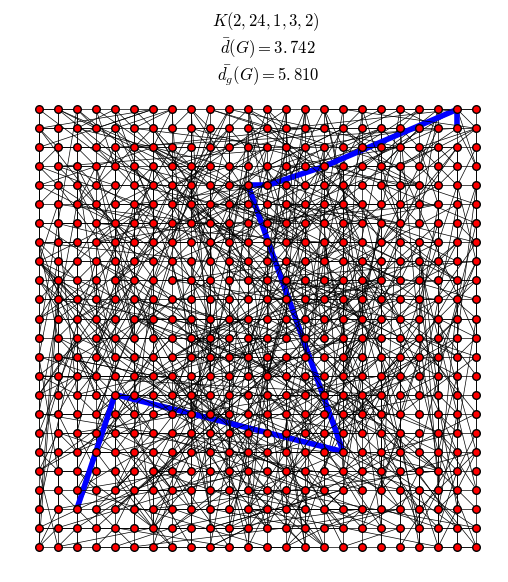

In [70]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: right;
    vertical-align: middle;
}
</style>
""")
plt.rcParams['figure.figsize'] = (6,6)
k = 2
n = 24
p = 1
q = 3
r = 2
G = kleinberg(n,p,q,r,k)
G = G.to_undirected()

# apl
agpl, srate = average_greedy_path_length(G,dim=2)
aspl = nx.average_shortest_path_length(G)

# draw route
src = (n//10, n//10 )
dst = (n - n//10, n - n//10)
path, labels, step = greedy_path(G, src, dst, dim=2)
eclist, ewlist = color_path(G, path, width_def=0.5)
pos=draw_autocrop_grid(G)

title = "$K({}, {}, {}, {}, {})$".format(k,n,p,q,r)
length = "\n $\\bar{d}(G)=%2.3f$ \n $\\bar{d_g}(G)=%2.3f$" % (aspl, agpl)
plt.title(title + length)
nx.draw(G, pos=pos, with_labels=False, node_size=30, node_color='r', edge_color=eclist, width=ewlist, font_size=30)

## 2.1 Navigable small-world network model (Kleinberg, 2000) 
### 2.1.5 例: 1次元の場合

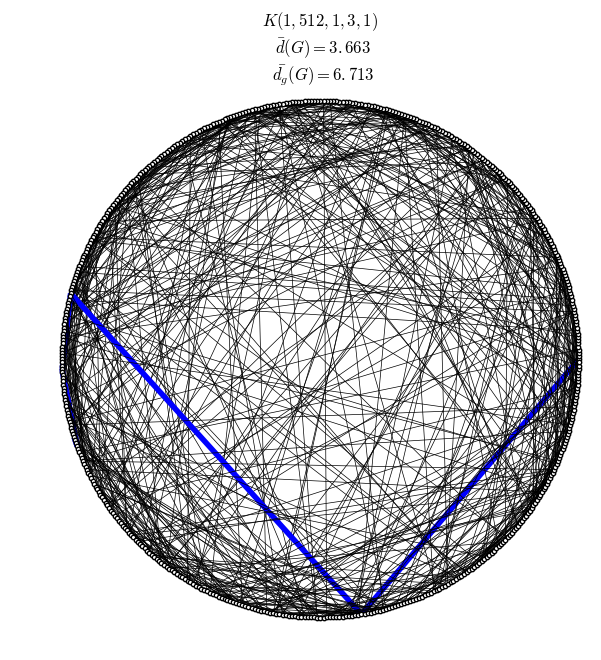

In [80]:
plt.rcParams['figure.figsize'] = (7,7)
k = 1
n = 512
p = 1
q = 3
r = 1
G = kleinberg(n,p,q,r,k)

# apl
agpl, srate = average_greedy_path_length(G)
aspl = nx.average_shortest_path_length(G)

# draw route
src = 0
dst = n // 2 + n //20
path, labels, step = greedy_path(G, src, dst)
eclist, ewlist = color_path(G, path)
pos=draw_autocrop(G)

title = "$K({}, {}, {}, {}, {})$".format(k,n,p,q,r)
length = "\n $\\bar{d}(G)=%2.3f$ \n $\\bar{d_g}(G)=%2.3f$" % (aspl, agpl)
plt.title(title + length)
nx.draw(G, pos=pos, with_labels=False, node_size=10, node_color='w', edge_color=eclist, width=ewlist, font_size=30)

## 2.2 Application to the routing in F2F overlay networks (Sandberg, 2006)
### 2.2.1 概要
- 信頼関係によるF2Fネットワークを構築した場合スモール・ワールド性を持つと仮定 (例: Web of Trust)
- Kleinberg(2000)では各ノードが自分の格子上での位置を知っていることが前提となっている
    - コンピュータのオーバーレイネットワークではこの前提が成り立たない
    - 各ノードに格子上の位置を割り当てる必要がある
- **Kleinbergモデルの復元**
    - 対象となるグラフの各ノードを1次元格子(リング)上の点に対応付ける (*embedding*)
    - 格子上に並べられたグラフがKleinbergのモデルから生起しやすくなるような*embedding* $\phi$を**MCMC**により求める
    - 得られた*embedding*によって各ノードの配置を決定後、分散ルーティングを実行

<figure>
    <center><img src="data/ict_fig_300.png", width=900></center>
</figure>

## 2.2 Application to the routing in F2F overlay networks (Sandberg, 2006)
### 2.2.1 (用語)
- *embedding*: 対象となるグラフのノードの格子グラフへの対応付け
- *base graph*: *embedding*先の格子グラフ
- *reverse engineering*: 位置情報を欠いたグラフからKleinbergモデルでの位置情報を復元する
- *location swapping*: M-Hアルゴリズムでembeddingの対応付けをある2つのノードについて入れ替える操作
- *dead-end*: 自分よりもターゲットに近い隣接ノードがいない状態
- *local/long-range contact*: 格子距離が最も近い隣接ノードとそうでない隣接ノード

## 2.2 Application to the routing in F2F overlay networks (Sandberg, 2006)
### 2.2.2 問題設定
- 「Kleinbergモデルで生成されたネットワークトポロジーが与えられ、かつ各ノードの格子上における座標情報がないとき、効率的な分散ルーティングが可能になるように座標情報を復元する」
    - → embedding $\phi$のパラメータ推定問題としてみなす
- $H = (V, E)$: 解析対象となるネットワーク ($E=\{1, 2,\ldots, m\}$とする)
- $G$: $k$次元格子, *base graph*
- $\phi: V \to G$:  全単射, *embedding*
- $\textrm{Pr}(\phi|E)$: エッジ集合$E$が観測された場合の$\phi$の事後分布
    - このとき尤度関数
$$\textrm{Pr} (E|\phi) = \displaystyle\prod_{i=1}^{m}\cfrac{1}{d(\phi(u_i), \phi(v_i))^{k}Z}$$
      を用いて, ベイズの定理から事後分布を以下のように書き直せる。


$$
\begin{eqnarray*}
\textrm{Pr}(\phi|E) &=&\cfrac{\textrm{Pr}(E|\phi)\textrm{Pr}(\phi)}{\textrm{Pr}(E)} \\
                    &=&\cfrac{\textrm{Pr}(\phi)}{\textrm{Pr}(E)}  \displaystyle\prod_{i=1}^{m}\cfrac{1}{d(\phi(u_i), \phi(v_i))^{k}Z}
\end{eqnarray*}
$$

### 2.2.2 (補足)
- $u_i, v_i$: エッジ$i$を持つノード
- $Z$はリングやトーラスであれば, どのノードを始点としても同じ値になる
- **TODO**: Kleinbergのモデルから本当にこの尤度関数となるのか

## 2.2 Application to the routing in F2F overlay networks (Sandberg, 2006)
### 2.2.3 Metropolis-Hastings アルゴリズム
- Metropolis-Hastingsアルゴリズムにより事後分布$\textrm{Pr}(\phi|E) $からembedding $\phi$をサンプリング
- $\phi_1$を現在の値, $\phi_2$を次の値候補として以下のように導かれた採択確率$\beta(\phi_1, \phi_2)$を用いる

$$
\begin{eqnarray*}
    \beta (\phi_1, \phi_2) &=& \min \left[1, \cfrac{\textrm{Pr}(\phi_2|E)\alpha(\phi_2, \phi_1)}{\textrm{Pr}(\phi_1|E)\alpha(\phi_1, \phi_2)}\right] \\
                           &=& \min \left[1, \cfrac{\textrm{Pr}(\phi_2|E)}{\textrm{Pr}(\phi_1|E)}\right] \\
                           &=& \min \left[1, \cfrac{\textrm{Pr}(E|\phi_2)}{\textrm{Pr}(E|\phi_1)}\right] \\
                           &=& \min \left[1, \prod_{i=1}^{m}\cfrac{d(\phi_1(u_i), \phi_1(v_i))^k}{d(\phi_2(u_i), \phi_2(v_i))^k}\right] \\
                           &=& \min \left[1, \prod_{i \in E(x \vee y)}^{}\cfrac{d(\phi_1(u_i), \phi_1(v_i))^k}{d(\phi_2(u_i), \phi_2(v_i))^k}\right] \\
\end{eqnarray*}
$$

- ただし, 
    - $\phi_1(x)=\phi_2 (y), \phi_1(y)=\phi_2 (x)$, and for all $z \neq x, y, \phi_1(z)=\phi_2(z)$ (つまり$\phi_2$は$\phi_1$の$x,y$の配置を入れ替えたもの)
    - $\alpha(\phi_1, \phi_2 ) = \alpha(\phi_2, \phi_1 )  =  \frac{1}{\left(n + \left( \begin{array}{c} n \\ 2 \end{array} \right)\right)}$  if $x,y$-switch, 0 otherwise : 提案分布, シンメトリック

    - $E(x \vee y)$ : $x$または$y$を端点に持つエッジの集合

### 2.2.3 (補足)
- 事前分布$\textrm{Pr}(\phi)$は一様分布とする
- **TODO**: 提案分布はなぜこれで良いのか
- **TODO**: 収束効率


## 2.2 Application to the routing in F2F overlay networks (Sandberg, 2006)
### 2.2.3 Metropolis-Hastings アルゴリズム
<figure>
    <center><img src="data/cite/sandberg_switch.png", width=800></center>
     <center><figcaption> <font size="4">How the node switching works</font></figcaption></center>
</figure>
<div align="right"> <font size="2">Sandberg, Oskar. "Distributed routing in small-worlds - Darknet", http://www.sandbergs.org/oskar/sw_darknet.pdf, 2006</font></div>

### 2.2.3 (補足)
- それぞれ$\phi_1, \phi_2$とする
- 赤, 青のノードを$x,y$とする
- 図では$\phi_1$における$x$とエッジを持つ各ノードと$x$の距離を計算 ($y$についても同様), $\phi_2$についても同様の計算を行う
- それらの距離を掛けあわせたものの比を取ってやる
- この図では$\phi_2$より$\phi_1$のほうが, 距離を掛けあわせた値が大きくなるので採択確率は1となり, 必ず$\phi_2$に推移する

## 2.2 Application to the routing in F2F overlay networks (Sandberg, 2006)
### 2.2.4 深さ優先探索
- Kleinbergのモデルではlocal-contactが必ず存在すると仮定しているため, ターゲットまでの距離は狭義に単調減少する
- しかし実データでこの仮定は成り立たないため, 行き止まり(*dead-end*)になる可能性がある
- *dead-end*に対応するためのルーティングアルゴリズムとして、ホップ数上限付の深さ優先探索を用いる
    1. リクエストの内容が過去に受け取ったものと同一であればリクエストを拒否。さもなくば2へ。
    2. 自分がターゲットである or ホップ数上限に達していれば終了。さもなくば3へ。
    3. 隣接ノードのうちターゲットに一番近いノードへリクエストをフォワード (Greedyルーティング)
    4. リクエストが拒否された場合、拒否したノードを候補から外し3を繰り返す。全ての隣接ノードから拒否された場合ルーティング失敗。
    

### 2.2.4 (補足)
- *dead-end*は厳密には2通りある
    1. 自分よりもターゲットに近くなるような隣接ノードがいない状態
    2. 全ての隣接ノードがすでに*visited*な状態
- c.f. Freenet 0.7の実装で使われるルーティングアルゴリズムは以下の通り(Evans, 2007)
    1. リクエストの内容が過去に一度来たものかどうかチェック。もし同じリクエストであれば, リクエストを拒否。
    2. 自分がターゲットのデータを持っている場合は成功。さもなくば3へ。
    3. もし現在の位置がリクエストがそれまでに辿ってきたどのノードよりもターゲットに近ければ$HTL$(hops-to-live)をリセット
    4. もしHTLが0になればリクエスト失敗。さもなくば5へ。
    5. すでに通ったノードを除いた自分の隣接ノードからターゲットに一番近いものにリクエストをフォワードし, リクエストにHTL-1と自分のノードIDを付加

## 2.2 Application to the routing in F2F overlay networks (Sandberg, 2006)
### 2.2.5 シミュレーション
#### 2つの実験
1. 人工的に生成したデータにM-Hアルゴリズムを適用
2. 実データ(Web of Trust)にM-Hアルゴリズムを適用

#### 3パターンのルーティングアルゴリズム
- Fail(F): dead-endに到達した時点でルーティング失敗とする
- Local Contact(LC): base graph上のlocal contactの使用を許す(Kleinbergの論文の手法と同様)
- Continue(C): 深さ優先探索。dead-endに到達したら隣接ノード中で最も近いノードを次のノードとして選択。ホップ数上限を$(\log_2 n)^2$とする。

## 2.2 Application to the routing in F2F overlay networks (Sandberg, 2006)
### 2.2.5 シミュレーション - 1. 人工的に生成したデータ
- *start*: Kleinbergのモデルに従って生成された直後のグラフ
- *random*: *start*の配置をランダムに入れ替えたグラフ
- *restored*: *random*にM-Hアルゴリズムを適用し, $6000n$回反復を行った後のグラフ

In [166]:
%%HTML
<figure class="onedim">
    <img src="data/sandberg_2006_1dim_start.png">
    <figcaption class="onedimcap">start</figcaption>
</figure>
<figure class="onedim">
    <img src="data/sandberg_2006_1dim_random.png">
     <figcaption class="onedimcap">random</figcaption>
</figure> 
<figure class="onedim">
    <img src="data/sandberg_2006_1dim_restored.png">
     <figcaption class="onedimcap">restored</figcaption>
</figure> 
<style>
.onedim {
    width: 33.3%;
    float: left;
    margin: 0;
    text-align: left;
    padding: 0;
}
.onedimcap {
    text-align: center;
}
</style>


## 2.2 Application to the routing in F2F overlay networks (Sandberg, 2006)
### 2.2.5 シミュレーション - 1. 人工的に生成したデータ
- *start*: Kleinbergのモデルに従って生成された直後のグラフ
- *random*: *start*の配置をランダムに入れ替えたグラフ
- *restored*: *random*にM-Hアルゴリズムを適用し, $6000n$回反復を行った後のグラフ

In [4]:
%%HTML
<figure class="subfig">
    <img src="data/cite/sandberg_2006_fig1.png">
</figure>
<figure class="subfig">
    <img src="data/cite/sandberg_2006_fig2.png">
</figure>
<div align="right"> <font size="2">Sandberg, Oskar. "Distributed routing in small-world networks." *Proceedings of the Meeting on Algorithm Engineering & Expermiments*. Society for Industrial and Applied Mathematics, 2006.</font></div>
<style>
.subfig {
    width: 50%;
    float: left;
    margin: 0;
    text-align: left;
    padding: 0;
}
</style>

## 2.2 Application to the routing in F2F overlay networks (Sandberg, 2006)
### 2.2.5 シミュレーション - 1. 人工的に生成したデータ
- *start*: Kleinbergのモデルに従って生成された直後のグラフ
- *random*: *start*の配置をランダムに入れ替えたグラフ
- *restored*: *random*にM-Hアルゴリズムを適用し, $6000n$回反復を行った後のグラフ

In [3]:
%%HTML
<figure class="subfig">
    <img src="data/cite/sandberg_2006_fig3.png">
</figure>
<figure class="subfig">
    <img src="data/cite/sandberg_2006_fig4.png">
</figure>
<div align="right"> <font size="2">Sandberg, Oskar. "Distributed routing in small-world networks." *Proceedings of the Meeting on Algorithm Engineering & Expermiments*. Society for Industrial and Applied Mathematics, 2006.</font></div>

## 2.2 Application to the routing in F2F overlay networks (Sandberg, 2006)
### 2.2.5 シミュレーション - 1. 人工的に生成したデータ
- 2次元格子に*embedding*した場合との比較
- (*restored*において各エッジが含むノード間の距離の合計)/(*start*において各エッジが含むノード間の距離の合計)

<figure>
    <center><img src="data/cite/sandberg_2006_fig12.png" width=600></center>
</figure>
<div align="right"> <font size="2">Sandberg, Oskar. "Distributed routing in small-world networks." *Proceedings of the Meeting on Algorithm Engineering & Expermiments*. Society for Industrial and Applied Mathematics, 2006.</font></div>

## 2.2 Application to the routing in F2F overlay networks (Sandberg, 2006)
### 2.2.5 シミュレーション - 2. 実データ (PGP公開鍵ネットワーク: Web of Trust)
- Web of Trust: PGP公開鍵の信頼性を保証するための仕組み。現実世界における知り合い関係のネットワークに対応する。
    - ノード: 公開鍵の所有者
    - エッジ: ノード間でデジタル署名が行われていれば存在(有向)
- 本論文ではリーフノードなど極端に次数の少ないノードを除いた2000ノードと4000ノードをサンプルとして抽出しテストを行っている

<figure>
    <center><img src="data/cite/wot2.gif" width=600></center>
</figure>
<div align="right"> <font size="2">Howlett, Tony. Open source security tools. Prentice Hall, 2004. </font></div>

## 2.2 Application to the routing in F2F overlay networks (Sandberg, 2006)
### 2.2.5 シミュレーション - 2. 実データ (PGP公開鍵ネットワーク: Web of Trust)
<figure class="subtabletwo">
    <center><img src="data/cite/sandberg_2006_table.png"></center>
</figure>
<div align="right"> <font size="2">Sandberg, Oskar. "Distributed routing in small-world networks." Proceedings of the Meeting on Algorithm Engineering & Expermiments. Society for Industrial and Applied Mathematics, 2006.</font></div>

## 2.2 Application to the routing in F2F overlay networks (Sandberg, 2006)
### 2.2.6 結論
- 提案されたM-Hアルゴリズムによってノードの位置交換を繰り返すことで, 効率の良い分散ルーティングが可能になる
- 人工的に生成されたデータに対しては, M-Hアルゴリズム適用の結果, 理想的な配置におけるホップ数に近づけることができる
- 実データに関してはdead-endに到達することが多く, Greedyアルゴリズムでは非効率となってしまう
    - ただし実データを対象にした他の先行研究の結果は成功率が更に低い
        - Liben-Nowell et al. (2005): 13%
        - Milgram (1967): 20%

# 3. 今後の課題と改良案
- Kleinberg(2000)のモデルはlocal contactが必ず存在するという仮定の上ルーティングが機能するとしているが, 現実的ではない。またスケールフリー性も無視している。
    - より現実に則したモデル(スモール・ワールドかつスケールフリーかつ分散ルーティング可能なモデル)に*embedding*する必要性
    - 例: Kleinberg(2002), Watts et al. (2002)
- M-Hアルゴリズムにおいて, 位置を入れ替えるノードの選択が分散的でない
    - 分散的に実装可能でかつ収束効率の良い提案分布を設定する必要性
- Web of Trust以外の社会ネットワークデータに対する実験
- 現実のネットワークは帯域等を考慮して重み付きエッジを用いるべき

## Freenet 0.7/0.7.5 の課題
    1. 効率性
        - モデルと現実のネットワークのトポロジーの差異によるembeddingしてもルーティングが必ずしもうまく行かない
    2. 安全性
        - アタッカーノードの存在を仮定した場合、安全性が保たれない
    3. 頑健性
        - 実際のネットワークは静的でなく、動的にノードが出入りする(=churn)。 この場合ルーティングの効率性が保証されない (Evans, 2007)